In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spikes = [5, 10]
drops = [0.0, 0.5]

data = []
filenames = []
for drop in drops:
    for i_spikes in spikes:
        file = "emopain_"
        mehtod = "srnn"
        suffix = f"_{i_spikes}sp_{drop}dp" 
        file += mehtod + suffix
        data_types = ["emg", "energy", "angle"]
        encoders = ["STL-S" , "STL-V"]
    
        for data_type in data_types:
            for encoder in encoders:
                results = pd.read_csv(f'../results/fixmi/{file}/results_{data_type}_{encoder}.csv', index_col=0)
                filenames.append(f"{file} {data_type} {encoder}")

                try:
                    results.set_index('fold', inplace=True)
                except Exception as e:
                    print(e)
                results.dropna(inplace=True)
                results.index = results.index.astype(int)
                # deduplicate the fold index
                results = results[~results.index.duplicated(keep='first')]
                try:
                    results['test_preds'] = results['test_preds'].apply(lambda x: int(x.strip('[]')))
                    results['test_labels'] = results['test_labels'].apply(lambda x: int(x.strip('[]')))
                except:
                    results['test_preds'] = results['ts_pred']
                    results['test_labels'] = results['ts_label']
                    results["test_acc"] = results["ts_acc"]
                print(f'{data_type}_{encoder}: {results.shape}')
                results.sort_index()
                
                if results.shape[0] == 47:
                    print(filenames[-1], "not of correct shape:", results.shape)
                data.append(results)
                
results_dict = {}
for i, d in enumerate(data):
    file, data_type, encoder = filenames[i].split(" ")
    filename = f"{file}_{data_type}_{encoder}"
    print(file, data_type, encoder)

    accuracies = d["test_acc"]
    sparsities = d["sparsity"]
    preds = d["test_preds"].to_numpy().flatten()
    labels = d["test_labels"].to_numpy().flatten()
    print(np.mean(accuracies))
    print(np.mean(sparsities))
    
    try:
        results_dict[filename]["accuracies"].append(np.mean(accuracies))
        results_dict[filename]["sparsities"].append(np.mean(sparsities))
        results_dict[filename]["labels"].append(labels)
        results_dict[filename]["preds"].append(preds)
    except:
        results_dict[filename] = {"accuracies": [np.mean(accuracies)],
                                "sparsities": [np.mean(sparsities)],
                                "preds": [preds],
                                "labels": [labels]}

emg_STL-S: (46, 6)
emg_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_STL-V: (46, 6)
emg_STL-S: (46, 6)
emg_STL-V: (46, 6)
energy_STL-S: (46, 6)
energy_STL-V: (46, 6)
angle_STL-S: (46, 6)
angle_STL-V: (33, 6)
emopain_srnn_5sp_0.0dp emg STL-S
32.608695652173914
0.3425944927536232
emopain_srnn_5sp_0.0dp emg STL-V
71.73913043478261
0.007371811594202865
emopain_srnn_5sp_0.0dp energy STL-S
71.73913043478261
0.5883686714975844
emopain_srnn_5sp_0.0dp energy STL-V
73.91304347826087
0.4404556521739131
emopain_srnn_5sp_0.0dp angle STL-S
73.91304347826087
0.7903682125603863
emopain_srnn_5sp_0.0dp angle STL-V
69.56521739130434
0.5296285265700483
emopain_srnn_10sp_0.0dp emg STL-S
67.3913043478261
0.33479061594202897


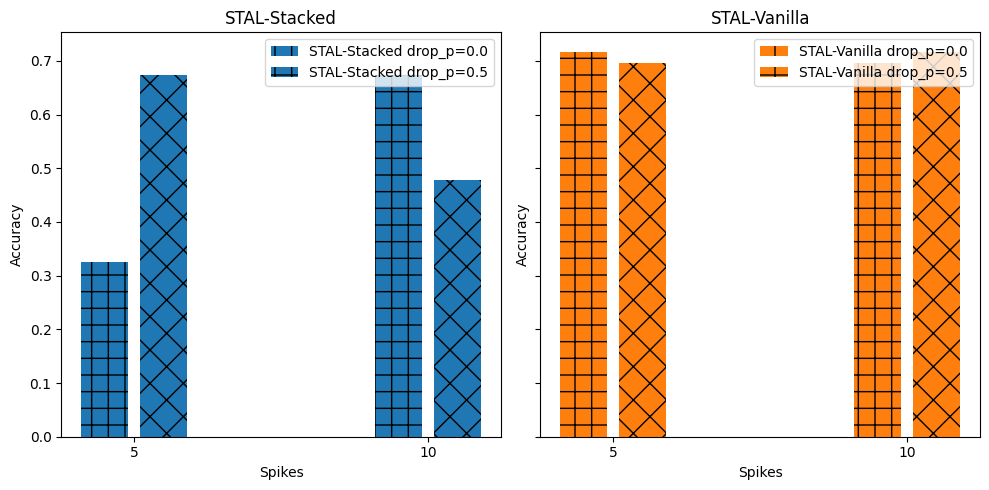

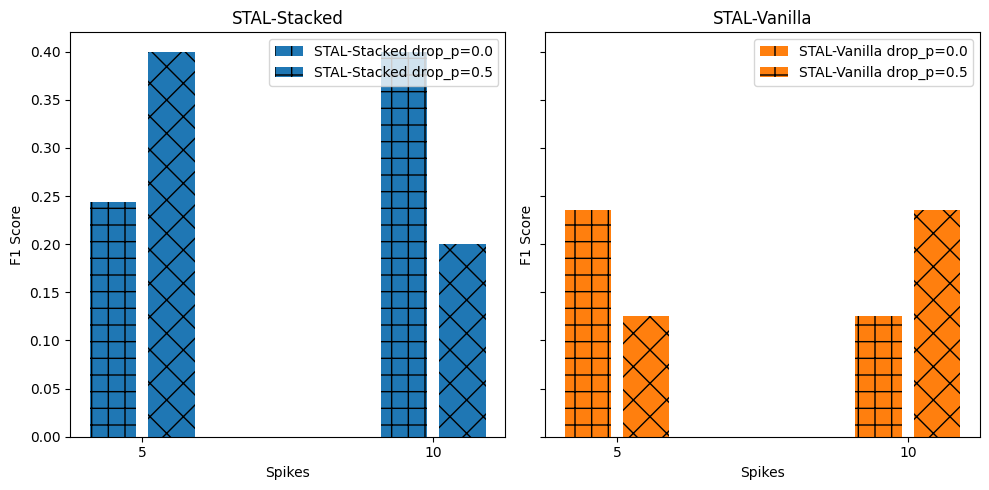

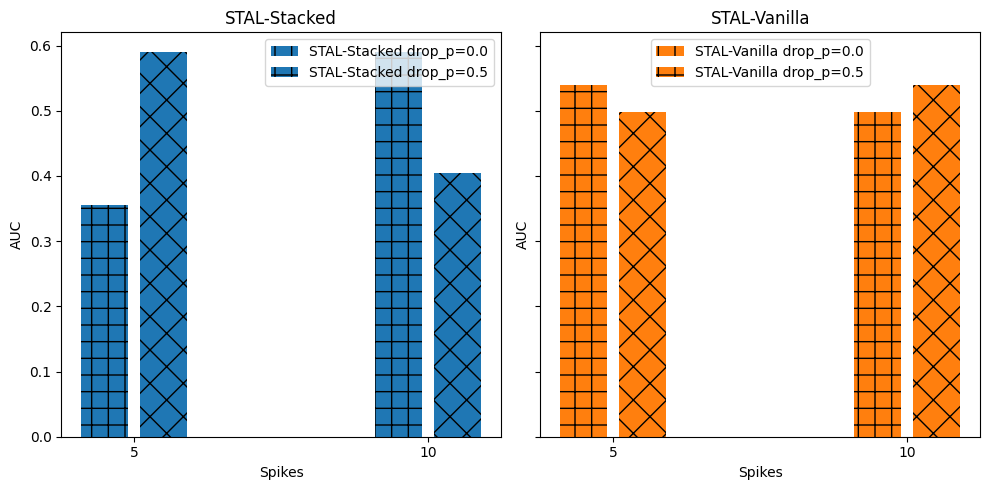

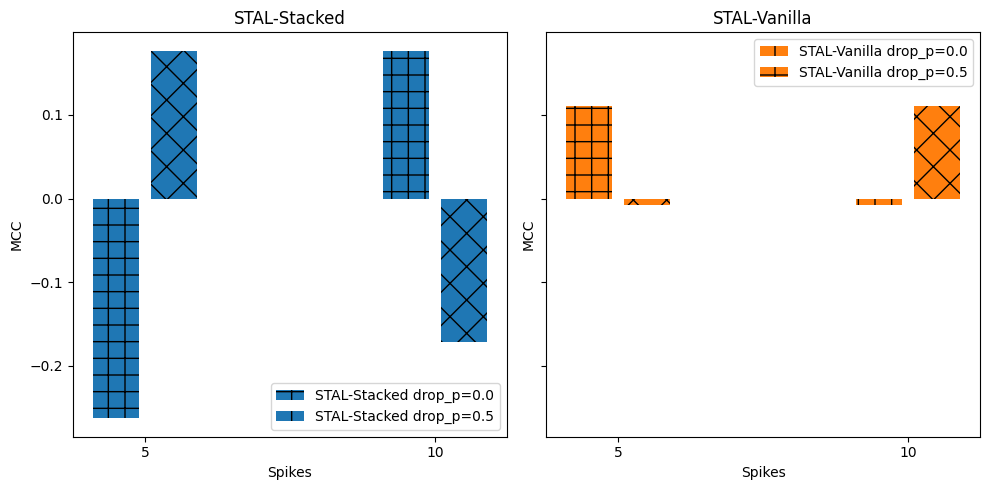

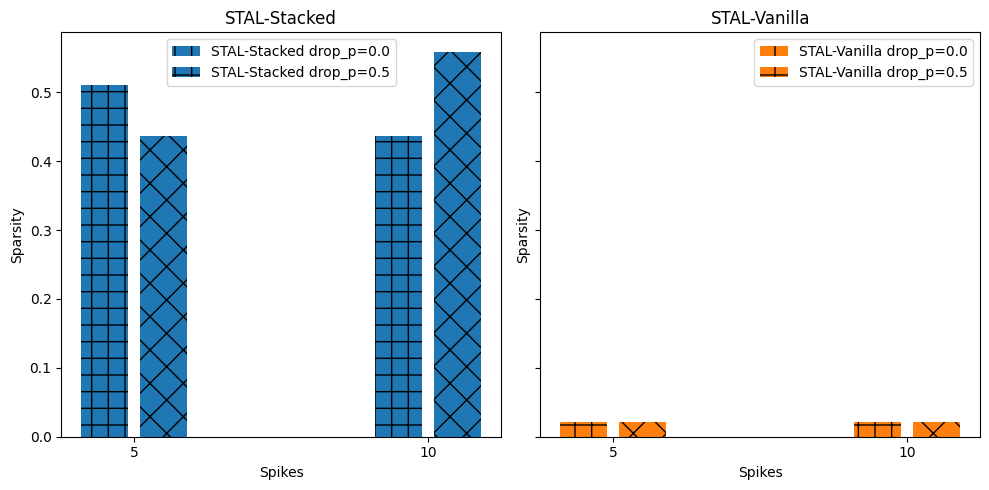

In [81]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from scipy.stats import hmean

# Extract data
accuracies = {encoder: [] for encoder in encoders}
f1s = {encoder: [] for encoder in encoders}
mccs = {encoder: [] for encoder in encoders}
aucs = {encoder: [] for encoder in encoders}
sparsities = {encoder: [] for encoder in encoders}

file = "emopain_srnn"
for drop in drops:
    for sp in spikes:
        for encoder in encoders:
            # Extract predictions and labels
            spikes_part = f"_{sp}sp_{drop}dp"
            
            emg_preds = results_dict[f'{file}{spikes_part}_emg_{encoder}']['preds'][0]
            emg_spars = results_dict[f'{file}{spikes_part}_emg_{encoder}']['sparsities'][0]
            energy_preds = results_dict[f'{file}{spikes_part}_energy_{encoder}']['preds'][0]
            energy_spars = results_dict[f'{file}{spikes_part}_energy_{encoder}']['sparsities'][0]
            angle_preds = results_dict[f'{file}{spikes_part}_angle_{encoder}']['preds'][0]
            angle_spars = results_dict[f'{file}{spikes_part}_angle_{encoder}']['sparsities'][0]
            labels = results_dict[f'{file}{spikes_part}_energy_{encoder}']['labels'][0]  # Assuming labels are the same for all data types

            # Calculate accuracy weights
            emg_acc = results_dict[f'{file}{spikes_part}_emg_{encoder}']['accuracies'][0]
            energy_acc = results_dict[f'{file}{spikes_part}_energy_{encoder}']['accuracies'][0]
            angle_acc = results_dict[f'{file}{spikes_part}_angle_{encoder}']['accuracies'][0]
            
            try:
                emg_f1 = f1_score(labels, emg_preds)
                energy_f1 = f1_score(labels, energy_preds)
                angle_f1 = f1_score(labels, angle_preds)
                
                emg_mcc = matthews_corrcoef(labels, emg_preds)
                energy_mcc = matthews_corrcoef(labels, energy_preds)
                angle_mcc = matthews_corrcoef(labels, angle_preds)
            except:
                emg_f1 = 0
                energy_f1 = 0
                angle_f1 = 0
                
                emg_mcc = 0
                energy_mcc = 0
                angle_mcc = 0

            weights = [emg_f1, energy_f1, angle_f1]
            # weights = [energy_acc, angle_acc]
            # weights = [1, 1, 1]

            # Perform accuracy-weighted majority voting
            try:
                ensemble_preds = np.round(
                    (emg_preds * weights[0] + energy_preds * weights[1] + angle_preds * weights[2]) / sum(weights)
                ).astype(int)
                
                # ensemble_preds = np.round(
                #     (energy_preds * weights[0] + angle_preds * weights[1]) / sum(weights)
                # ).astype(int)
            
                accuracies[encoder].append(accuracy_score(labels, ensemble_preds))
                f1s[encoder].append(f1_score(labels, ensemble_preds))
                mccs[encoder].append(matthews_corrcoef(labels, ensemble_preds))
                aucs[encoder].append(roc_auc_score(labels, ensemble_preds))
                sparsities[encoder].append(hmean([emg_spars, energy_spars, angle_spars]))
                # sparsities[encoder].append(hmean([energy_spars, angle_spars]))
            except:
                accuracies[encoder].append(np.nan)
                f1s[encoder].append(np.nan)
                mccs[encoder].append(np.nan)
                aucs[encoder].append(np.nan)
                sparsities[encoder].append(np.nan)

# different markers
markers = ['+', 'X']

enc_names = {"STL-V": "STAL-Vanilla", "STL-S": "STAL-Stacked"}

def plot_metrics(metrics, metric_name, encoders, drops, spikes):
    q = 0
    fig, axs = plt.subplots(1, len(encoders), figsize=(10, 5), sharey=True)
    if len(encoders) == 1:
        axs = [axs]
    
    for d, dr in enumerate(drops):
        for s, sp in enumerate(spikes):
            for i, encoder in enumerate(encoders):
                if encoder == "STL-S":
                    c = 'tab:blue'
                if encoder == "STL-V":
                    c = 'tab:orange'
                key = f"{encoder}"
                if key in metrics:
                    if d == 0:
                        axs[i].bar(sp-0.5, metrics[key][d+s], hatch=markers[d], color=c)
                    else:
                        axs[i].bar(sp+0.5, metrics[key][d+s], hatch=markers[d], color=c)
                    axs[i].set_title(f"{enc_names[encoder]}")
                    axs[i].set_xlabel("Spikes")
                    axs[i].set_xticks(spikes)
                    axs[i].set_ylabel(metric_name)
                    axs[i].legend([f"{enc_names[encoder]} drop_p=0.0", f"{enc_names[encoder]} drop_p=0.5"])
            q+=1
    plt.tight_layout()
    plt.show()

# Plotting the metrics
plot_metrics(accuracies, "Accuracy", encoders, drops, spikes)
plot_metrics(f1s, "F1 Score", encoders, drops, spikes)
plot_metrics(aucs, "AUC", encoders, drops, spikes)
plot_metrics(mccs, "MCC", encoders, drops, spikes)
plot_metrics(sparsities, "Sparsity", encoders, drops, spikes)
